In [22]:
from __future__ import print_function
from IPython.display import clear_output

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import random
import cv2
import functools

import torch
import torchvision
import torch.nn as nn
from torch.nn import init
import torchvision.transforms as transforms
from  torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

In [23]:
is_notebook = True

In [24]:
if is_notebook:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

### Utils

In [25]:
def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


def get_option_setter(model_name):
    """Return the static method <modify_commandline_options> of the model class."""
    model_class = Pix2PixModel
    return model_class.modify_commandline_options

In [26]:
class Pix2PixModel():
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        parser.set_defaults(norm='batch', netG='unet_256', dataset_mode='aligned')
        if is_train:
            parser.set_defaults(pool_size=0, gan_mode='vanilla')
            parser.add_argument('--lambda_L1', type=float, default=100.0, help='weight for L1 loss')

        return parser
    
    def __init__(self, opt):
        self.opt = opt
        self.gpu_ids = opt.gpu_ids
        self.isTrain = opt.isTrain
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')  # get device name: CPU or GPU
        self.save_dir = os.path.join(opt.checkpoints_dir)  # save all the checkpoints to save_dir
        if opt.preprocess != 'scale_width':  # with [scale_width], input images might have different sizes, which hurts the performance of cudnn.benchmark.
            torch.backends.cudnn.benchmark = True
        self.loss_names = []
        self.model_names = []
        self.visual_names = []
        self.optimizers = []
        self.image_paths = []
        self.metric = 0  # used for learning rate policy 'plateau'
    
        # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
        self.loss_names = ['G_GAN', 'G_L1', 'D_real', 'D_fake']
        # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
        self.visual_names = ['real_A', 'fake_B', 'real_B']
        # specify the models you want to save to the disk. The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>
        if self.isTrain:
            self.model_names = ['G', 'D']
        else:  # during test time, only load G
            self.model_names = ['G']
        # define networks (both generator and discriminator)
        self.netG = define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                      not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:  # define a discriminator; conditional GANs need to take both input and output images; Therefore, #channels for D is input_nc + output_nc
            self.netD = define_D(opt.input_nc + opt.output_nc, opt.ndf, opt.netD,
                                          opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:
            # define loss functions
            self.criterionGAN = GANLoss(opt.gan_mode).to(self.device)
            self.criterionL1 = torch.nn.L1Loss()
            # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
            self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)



    def set_input(self, inputs, targets):
        self.real_A = inputs.to(self.device)
        self.real_B = targets.to(self.device)

    def forward(self):
        self.fake_B = self.netG(self.real_A)

    def backward_D(self):
        # Fake; stop backprop to the generator by detaching fake_B
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)  # we use conditional GANs; we need to feed both input and output to the discriminator

        pred_fake = self.netD(fake_AB.detach())

        self.loss_D_fake = self.criterionGAN(pred_fake, False)
        # Real
        real_AB = torch.cat((self.real_A, self.real_B), 1)
        pred_real = self.netD(real_AB)
        self.loss_D_real = self.criterionGAN(pred_real, True)
        # combine loss and calculate gradients
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        # First, G(A) should fake the discriminator
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)

        pred_fake = self.netD(fake_AB)
        self.loss_G_GAN = self.criterionGAN(pred_fake, True)
        # Second, G(A) = B
        self.loss_G_L1 = self.criterionL1(self.fake_B, self.real_B) * self.opt.lambda_L1
        # combine loss and calculate gradients
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()                   # compute fake images: G(A)
        # update D
        self.set_requires_grad(self.netD, True)  # enable backprop for D
        self.optimizer_D.zero_grad()     # set D's gradients to zero
        self.backward_D()                # calculate gradients for D
        self.optimizer_D.step()          # update D's weights
        # update G
        self.set_requires_grad(self.netD, False)  # D requires no gradients when optimizing G
        self.optimizer_G.zero_grad()        # set G's gradients to zero
        self.backward_G()                   # calculate graidents for G
        self.optimizer_G.step()             # udpate G's weights

    def setup(self, opt):
        if self.isTrain:
            self.schedulers = [get_scheduler(optimizer, opt) for optimizer in self.optimizers]
        if opt.continue_train:
            load_suffix = 'epoch%d' % opt.epoch_count
            self.load_networks(load_suffix)
        self.print_networks(opt.verbose)


    def update_learning_rate(self):
        for scheduler in self.schedulers:
            scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate = %.7f' % lr)

    def get_current_losses(self):
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number
        return errors_ret

    def save_networks(self, epoch):
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    torch.save(net.module.cpu().state_dict(), save_path)
                    net.cuda(self.gpu_ids[0])
                else:
                    torch.save(net.cpu().state_dict(), save_path)

    def __patch_instance_norm_state_dict(self, state_dict, module, keys, i=0):
        """Fix InstanceNorm checkpoints incompatibility (prior to 0.4)"""
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))
            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))
        else:
            self.__patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

    def load_networks(self, epoch):
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)

    def print_networks(self, verbose):
        print('---------- Networks initialized -------------')
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                num_params = 0
                for param in net.parameters():
                    num_params += param.numel()
                if verbose:
                    print(net)
                print('[Network %s] Total number of parameters : %.3f M' % (name, num_params / 1e6))
        print('-----------------------------------------------')

    def set_requires_grad(self, nets, requires_grad=False):
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad


### Models

In [27]:
class Identity(nn.Module):
    def forward(self, x):
        return x


In [28]:
def get_norm_layer(norm_type='instance'):
    norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    return norm_layer


def get_scheduler(optimizer, opt):
    def lambda_rule(epoch):
        lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.n_epochs) / float(opt.n_epochs_decay + 1)
        return lr_l
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    return scheduler

def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):

    norm_layer = get_norm_layer(norm_type=norm)
    net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    
    return init_net(net, init_type, init_gain, gpu_ids)


def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    norm_layer = get_norm_layer(norm_type=norm)
    net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    return init_net(net, init_type, init_gain, gpu_ids)


class GANLoss(nn.Module):
    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        self.loss = nn.BCEWithLogitsLoss()
    
    def get_target_tensor(self, prediction, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        target_tensor = self.get_target_tensor(prediction, target_is_real)
        loss = self.loss(prediction, target_tensor)
        return loss

class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)


class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

In [29]:
import argparse
import os

class BaseOptions():
    def __init__(self):
        self.initialized = False

    def initialize(self, parser):
        parser.add_argument('--name', type=str, default='experiment_name', help='name of the experiment. It decides where to store samples and models')
        parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
        parser.add_argument('--checkpoints_dir', type=str, default='./results', help='models are saved here')
        # model parameters
        parser.add_argument('--model', type=str, default='cycle_gan', help='chooses which model to use. [cycle_gan | pix2pix | test | colorization]')
        parser.add_argument('--input_nc', type=int, default=3, help='# of input image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--output_nc', type=int, default=3, help='# of output image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in the last conv layer')
        parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in the first conv layer')
        parser.add_argument('--netD', type=str, default='basic', help='specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator')
        parser.add_argument('--netG', type=str, default='resnet_9blocks', help='specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]')
        parser.add_argument('--n_layers_D', type=int, default=3, help='only used if netD==n_layers')
        parser.add_argument('--norm', type=str, default='instance', help='instance normalization or batch normalization [instance | batch | none]')
        parser.add_argument('--init_type', type=str, default='normal', help='network initialization [normal | xavier | kaiming | orthogonal]')
        parser.add_argument('--init_gain', type=float, default=0.02, help='scaling factor for normal, xavier and orthogonal.')
        parser.add_argument('--no_dropout', action='store_true', help='no dropout for the generator')
        # dataset parameters
        parser.add_argument('--dataset_mode', type=str, default='unaligned', help='chooses how datasets are loaded. [unaligned | aligned | single | colorization]')
        parser.add_argument('--direction', type=str, default='AtoB', help='AtoB or BtoA')
        parser.add_argument('--serial_batches', action='store_true', help='if true, takes images in order to make batches, otherwise takes them randomly')
        parser.add_argument('--num_threads', default=4, type=int, help='# threads for loading data')
        parser.add_argument('--batch_size', type=int, default=1, help='input batch size')
        parser.add_argument('--load_size', type=int, default=286, help='scale images to this size')
        parser.add_argument('--crop_size', type=int, default=256, help='then crop to this size')
        parser.add_argument('--max_dataset_size', type=int, default=float("inf"), help='Maximum number of samples allowed per dataset. If the dataset directory contains more than max_dataset_size, only a subset is loaded.')
        parser.add_argument('--preprocess', type=str, default='resize_and_crop', help='scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]')
        parser.add_argument('--no_flip', action='store_true', help='if specified, do not flip the images for data augmentation')
        parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')
        # additional parameters
        parser.add_argument('--epoch', type=str, default='latest', help='which epoch to load? set to latest to use latest cached model')
        parser.add_argument('--load_iter', type=int, default='0', help='which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]')
        parser.add_argument('--verbose', action='store_true', help='if specified, print more debugging information')
        parser.add_argument('--suffix', default='', type=str, help='customized suffix: opt.name = opt.name + suffix: e.g., {model}_{netG}_size{load_size}')
        self.initialized = True
        return parser

    def gather_options(self):
        if not self.initialized:  # check if it has been initialized
            parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
            parser = self.initialize(parser)

        # get the basic options
        opt, _ = parser.parse_known_args()

        # modify model-related parser options
        model_name = opt.model
        model_option_setter = get_option_setter(model_name)
        parser = model_option_setter(parser, self.isTrain)
        opt, _ = parser.parse_known_args()  # parse again with new defaults

        # save and return the parser
        self.parser = parser
        opt, _ = parser.parse_known_args()
        return opt

    def print_options(self, opt):
        message = ''
        message += '----------------- Options ---------------\n'
        for k, v in sorted(vars(opt).items()):
            comment = ''
            default = self.parser.get_default(k)
            if v != default:
                comment = '\t[default: %s]' % str(default)
            message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
        message += '----------------- End -------------------'
        print(message)

    def parse(self):

        opt = self.gather_options()
        opt.isTrain = self.isTrain   # train or test

        # process opt.suffix
        if opt.suffix:
            suffix = ('_' + opt.suffix.format(**vars(opt))) if opt.suffix != '' else ''
            opt.name = opt.name + suffix

        self.print_options(opt)

        # set gpu ids
        str_ids = opt.gpu_ids.split(',')
        opt.gpu_ids = []
        for str_id in str_ids:
            id = int(str_id)
            if id >= 0:
                opt.gpu_ids.append(id)
        if len(opt.gpu_ids) > 0:
            torch.cuda.set_device(opt.gpu_ids[0])
        self.opt = opt
        return self.opt


In [53]:
class TrainOptions(BaseOptions):
    """This class includes training options.

    It also includes shared options defined in BaseOptions.
    """

    def initialize(self, parser):
        parser = BaseOptions.initialize(self, parser)
        # visdom and HTML visualization parameters
        parser.add_argument('--display_freq', type=int, default=400, help='frequency of showing training results on screen')
        parser.add_argument('--display_ncols', type=int, default=4, help='if positive, display all images in a single visdom web panel with certain number of images per row.')
        parser.add_argument('--display_id', type=int, default=1, help='window id of the web display')
        parser.add_argument('--display_server', type=str, default="http://localhost", help='visdom server of the web display')
        parser.add_argument('--display_env', type=str, default='main', help='visdom display environment name (default is "main")')
        parser.add_argument('--display_port', type=int, default=8097, help='visdom port of the web display')
        parser.add_argument('--update_html_freq', type=int, default=1000, help='frequency of saving training results to html')
        parser.add_argument('--print_freq', type=int, default=100, help='frequency of showing training results on console')
        parser.add_argument('--no_html', action='store_true', help='do not save intermediate training results to [opt.checkpoints_dir]/[opt.name]/web/')
        # network saving and loading parameters
        parser.add_argument('--save_latest_freq', type=int, default=5000, help='frequency of saving the latest results')
        parser.add_argument('--save_epoch_freq', type=int, default=5, help='frequency of saving checkpoints at the end of epochs')
        parser.add_argument('--save_by_iter', action='store_true', help='whether saves model by iteration')
        parser.add_argument('--continue_train', action='store_true', help='continue training: load the latest model')
        parser.add_argument('--epoch_count', type=int, default=0, help='the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
        parser.add_argument('--phase', type=str, default='train', help='train, val, test, etc')
        # training parameters
        parser.add_argument('--n_epochs', type=int, default=100, help='number of epochs with the initial learning rate')
        parser.add_argument('--n_epochs_decay', type=int, default=100, help='number of epochs to linearly decay learning rate to zero')
        parser.add_argument('--beta1', type=float, default=0.5, help='momentum term of adam')
        parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')
        parser.add_argument('--gan_mode', type=str, default='lsgan', help='the type of GAN objective. [vanilla| lsgan | wgangp]. vanilla GAN loss is the cross-entropy objective used in the original GAN paper.')
        parser.add_argument('--pool_size', type=int, default=50, help='the size of image buffer that stores previously generated images')
        parser.add_argument('--lr_policy', type=str, default='linear', help='learning rate policy. [linear | step | plateau | cosine]')
        parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')

        self.isTrain = True
        return parser


In [31]:
import os
def get_meta(root_dir):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths = []
    
    for entry in os.scandir(root_dir):
        if (entry.is_file()):
            paths.append(entry.path)
    return paths

In [32]:
if is_notebook:
    root_dir_A = "./data/trainA/"
    root_dir_B = "./data/trainB/"
else:
    root_dir_A = "/nobackup/sc19adpm/DeepStreetsData/trainA/"
    root_dir_B = "/nobackup/sc19adpm/DeepStreetsData/trainB/"

paths_A = get_meta(root_dir_A)
paths_B = get_meta(root_dir_B)

data = {
    'A': paths_A,
    'B': paths_B
}
data_df = pd.DataFrame(data, columns=['A', 'B'])
data_df = data_df.sample(frac=1).reset_index(drop=True)

In [33]:
data_df.head()

,A,B
0,./data/trainA/se3136_13.jpg,./data/trainB/se3136_13.jpg
1,./data/trainA/se2635_83.jpg,./data/trainB/se2635_83.jpg
2,./data/trainA/se2632_39.jpg,./data/trainB/se2632_39.jpg
3,./data/trainA/se3139_132.jpg,./data/trainB/se3139_132.jpg
4,./data/trainA/se2738_46.jpg,./data/trainB/se2738_46.jpg


In [34]:
from PIL import Image
import cv2
from torch.utils.data import Dataset

class Streets(Dataset):
    def __init__(self, df, transform_A, transform_B):
        self.df = df
        self.transform_A = transform_A
        self.transform_B = transform_B
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        x = Image.open(open(self.df['A'][index], 'rb')) 
        y = Image.open(open(self.df['B'][index], 'rb')) 
        
        x = self.transform_A(x)
        y = self.transform_B(y)
        return x, y 
        

In [35]:
def __crop(img, pos, size):
    ow, oh = img.size
    x1, y1 = pos
    tw = th = size
    if (ow > tw or oh > th):
        return img.crop((x1, y1, x1 + tw, y1 + th))
    return img

def __flip(img, flip):
    if flip:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img

In [36]:
w = 256
h = 256
new_h = h
new_w = w
new_h = 256
new_w = 256

x = random.randint(0, np.maximum(0, new_w - 256))
y = random.randint(0, np.maximum(0, new_h - 256))

flip = random.random() > 0.5


data_transform_A = transforms.Compose([
        transforms.Resize((256,256), Image.BICUBIC),
        transforms.Lambda(lambda img: __crop(img, (x, y), 256)),
        transforms.Lambda(lambda img: __flip(img, flip)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Should we use a transform for B too? (Yes, they do)
data_transform_B = transforms.Compose([
        transforms.Resize((256,256), Image.BICUBIC),
        transforms.Lambda(lambda img: __crop(img, (x, y), 256)),
        transforms.Lambda(lambda img: __flip(img, flip)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [37]:
train_split = 1 # Defines the ratio of train/valid/test data.
valid_split = 0

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = Streets(
    df=data_df[:train_size],
    transform_A=data_transform_A,
    transform_B=data_transform_B
)

ins_dataset_valid = Streets(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform_A=data_transform_A,
    transform_B=data_transform_B
)

ins_dataset_test = Streets(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform_A=data_transform_A,
    transform_B=data_transform_B
)

In [38]:
batch_size = 1
train_loader = DataLoader(dataset=ins_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=ins_dataset_test, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(dataset=ins_dataset_valid, batch_size=batch_size, shuffle=False)

In [39]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
opt = TrainOptions().parse()   # get training options

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./results                     
           continue_train: False                         
                crop_size: 256                           
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1                             
                 gan_mode: van

In [51]:
model = Pix2PixModel(opt)
model.setup(opt)

initialize network with normal
initialize network with normal
loading the model from ./results/latest_net_G.pth
loading the model from ./results/latest_net_D.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
[Network D] Total number of parameters : 2.769 M
-----------------------------------------------


In [52]:
opt.epoch_count

1

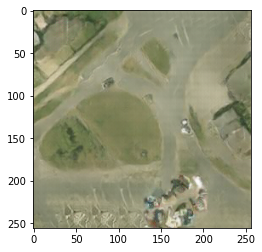

Epoch [1/1000], Step [1/8164]



KeyboardInterrupt: 

In [49]:
num_epochs = 1000
for epoch in range(opt.epoch_count, num_epochs):
    loss_D_list = []
    loss_G_list = []
    acc_list = []
    for i, (inputs, targets) in enumerate(tqdm(train_loader)):
        
        model.set_input(inputs, targets)         # unpack data from dataset and apply preprocessing
        model.optimize_parameters()   # calculate loss functions, get gradients, update network weights
        model.forward()
        
        if (is_notebook) and (i % 100 == 0):
            clear_output(wait=True)
            plt.figure(0) # Here's the part I need
            img = tensor2im(model.fake_B)
            plt.imshow(img)
            plt.show()
            print('Epoch [{}/{}], Step [{}/{}]'
                  .format(epoch + 1, num_epochs, i+1, len(train_loader)))
        
        # Track the accuracy
    model.update_learning_rate()    
    print('Epoch [{}/{}]'
              .format(epoch + 1, num_epochs))
    if (not is_notebook) and ((epoch + 1) % 5 == 0):
        idx = random.randint(0, len(paths_A) - 1)
        img_A = Image.open(paths_A[idx])
        img = data_transform_A(img_A)
        img = torch.from_numpy(np.expand_dims(img, axis=0))
        img = img.to(model.device)
        out = model.netG(img)
        img_B_fake = tensor2im(out)
        img_B_real = Image.open(paths_B[idx])
        img = np.concatenate((img_A, img_B_fake, img_B_real), axis=1) 
        plt.imshow(img)
        plt.show()
        plt.imsave('results/{}.jpg'.format(epoch), img)
        model.save_networks('epoch{}'.format(epoch + 1))